### Импорт библиотек

In [1]:
import glob
import json
import logging
import os
import psycopg2
import requests
import smtplib
import ssl
from datetime import datetime, timedelta
from email.message import EmailMessage
from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build
from re import search, match

In [2]:
beg = datetime.now() # хочу узнать время выполнения скрипта

#### Создание функции для логгирования

In [3]:
def set_logs(current_date):
    log_filename = f'app_{current_date.strftime('%Y-%m-%d')}.log'    
    # Настройка логирования в файл
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        filename=log_filename,
        filemode='a'
    )


#### Создание функция для удаления файлов со старыми логгами

In [4]:
def delete_old_logs(log_dir='.', days=3):
    pattern = r'\d{4}-\d{2}-\d{2}' # паттерн для поиска нужного файла
    for file in glob.glob(log_dir + '/*.log'):
        try:
            date_str = search(pattern, file).group()
            file_date = datetime.strptime(date_str, '%Y-%m-%d').date()
            if current_date - file_date >= timedelta(days=days): # если файлы давние      
                os.remove(file) # удаление файла
                logging.info(f'Удален старый лог-файл: {file}')
        except Exception as e:
            logging.warning(f'Не удалось обработать файл {file}: {e}, {date_str}')

#### Создание класса для подключения к базе данных

In [5]:
class DatabaseConnection:
    _instance = None

    def __new__(cls, *args):
        if not cls._instance:
            cls._instance = super().__new__(cls)
        else: 
            logging.warning(f'Повторное создание экземпляра класса для подключения к базе данных.')
        return cls._instance
        
    def __init__(self, database, user, password, host, port):
        try:
            if not hasattr(self, 'instance'):  # Проверяем, существует ли экземпляр
                self.__database = database
                self.__user = user
                self.__password = password
                self.__host = host
                self.__port = port
        except Exception as e:
            logging.error(f'Ошибка подключения к базе данных: {e}')

    
    def __enter__(self):
        try:
            self.connection = psycopg2.connect(database=self.__database, 
                                                    user=self.__user, 
                                                password=self.__password,
                                                    host=self.__host, 
                                                    port=self.__port)
            self.cursor = self.connection.cursor()
            self.status = True
            logging.info(f'Подключение к базе данных успешно установлено')
        except Exception as e:
            self.status = False
            logging.error(f'Ошибка подключения к базе данных: {e}')
        return self

    def __exit__(self, exc_type, exc_val, exc_tb): # закрытие соединения
        self.cursor.close()
        self.connection.close()
        logging.info(f'Соединение с базой данных закрыто.')    

    def try_query(self, query, params=None): # обычные запросы + параметризированные запросы
        try: 
            if params:
                self.cursor.execute(query, params)
            else:
                self.cursor.execute(query)
            logging.info(f'Запрос выполнен успешно')    
            return self.cursor.fetchall()
        except Exception as e:
            logging.error(f'Ошибка при выполнении запроса: {e}')
            self.connection.rollback()

    def insert_data(self, insert_query, data): # для вставки данных отдельный метод
        try:
            self.cursor.executemany(insert_query, data)
            self.connection.commit()
            logging.info(f'Добавлено записей: {len(data)}')
        except Exception as e:
            logging.error(f'Ошибка при вставке данных: {e}')
            self.connection.rollback()


#### Создание класса для подключения по API

In [6]:
class GetRequests:
    def __init__(self, api_url, params):
        try:
            self.res = requests.get(api_url, params)
            self.status_code = self.res.status_code
            self.url = self.res.url
            self.res_list = self.res.json()
            if self.status_code == 200:
                logging.info(f'Данные получены, status_code = 200')
            else: 
                logging.error(f'Ошибка получения данных: status_code =  {self.status_code}')
        except Exception as e:
            logging.error(f'Ошибка подключения по API: {e}')            

#### Создание класса для работы с google sheets

In [7]:
class SheetWrite:
    def __init__(self, service_account_file, spreadsheet_id):
        try:
            self.creds = Credentials.from_service_account_file(service_account_file,
                                                                    scopes=['https://www.googleapis.com/auth/spreadsheets', 
                                                                            'https://www.googleapis.com/auth/drive']
                                                                        )
            self.spreadsheet_id = spreadsheet_id
            self.service = build('sheets', 'v4', credentials=self.creds)
            logging.info(f'Подключение к google sheets выполнено')
        except Exception as e:
            logging.error(f'Ошибка подключения  к google sheets: {e}')                

    def append_to_table(self, data, range_name, value_Input_Option='RAW'):
        try:
            self.request = self.service.spreadsheets().values().append(
                                                    spreadsheetId=self.spreadsheet_id,
                                                            range=range_name,
                                                valueInputOption=value_Input_Option,  # чтобы распозналось как дата и число
                                                insertDataOption='INSERT_ROWS',
                                                            body={'values': data}
                                                              )
            self.response = self.request.execute()
            self.status = True # статус выполнения
            logging.info(f'Данные в google sheets на лист {range_name} добавлены')
        except Exception as e:
            self.status = False
            logging.error(f'Ошибка добавления строк в google sheets: {e}')

    def close_connection(self):
         self.service.close()
         logging.info(f'Соединение с google sheets закрыто')

#### Определяем постоянные переменные для подключения к БД, API, google sheets

In [8]:
current_date = datetime.now().date()
# previous_date = current_date - timedelta(days=1)

set_logs(current_date) # запуск логгирования
delete_old_logs() # удаление старых файлов с логгами

# подключение к бд
DATABASE='...'
USER='...'
PASSWORD='...'
HOST='...'
PORT='...'

# свежих данных нет на b2b, поэтому здесь исскуственно определила текущую дату для получение данных по API
# по задумке скрипт, допустим, запускался бы в 10 утра и забирал бы данные за предыдущий день=
current_date = (datetime.now() - timedelta(days=820)).date()
previous_date = current_date - timedelta(days=1)

# подключение по API
API_URL = 'https://.../api/statistics'
PARAMS = {
    'client': '...',
    'client_key': '...',
    'start': f'{previous_date.strftime("%Y-%m-%d %H:%M:%S.0")}', #'2023-04-01 00:00:00.0',
    'end': f'{current_date.strftime("%Y-%m-%d %H:%M:%S.0")}'
}

# подключение к google sheets
SERVICE_ACCOUNT_FILE = 'C:....json'
SPREADSHEET_ID = '...'  

#### Получение данных по API, подключение к google sheets (создание экземпяров класса)

In [9]:
data_api = GetRequests(API_URL, PARAMS)

In [10]:
write_gs = SheetWrite(SERVICE_ACCOUNT_FILE, SPREADSHEET_ID)

#### Формирование данных для загрузки в БД

In [12]:
data_for_insert = [] # список для валидных записей, которые будут записаны в бд
not_valid = [] # список для невалидных записей
if data_api.status_code == 200: # если получены данные и открыто соединение с бд
    for item in data_api.res_list:
      # валидность lti_user_id
      lti_user_id = str(item['lti_user_id']) #сразу переводим в тип данных str
      if lti_user_id == 'None' or not lti_user_id.isalnum():
          not_valid.append((item, f'non-valid  --lti_user_id--: {lti_user_id}')) # добавление невалиндой строки и обозначение неправильныъ данных
          continue # если неправильные данные, то запись улетает в невалидный список, переход на следующую итерацию цикла
             
      if item['passback_params'] is not None:
           passback_params = json.loads(item['passback_params'].replace("'", '"'))
          
           oauth_consumer_key = 'None' if not passback_params.get('oauth_consumer_key', None) else str(passback_params.get('oauth_consumer_key', None))

           # валидность lis_result_sourcedid       
           lis_result_sourcedid = str(passback_params.get('lis_result_sourcedid', None))
           pattern = r'course-v1:SkillFactory+'
           if lis_result_sourcedid == 'None' or not match(pattern, lis_result_sourcedid):
               logging.warning(f'non-valid --lis_result_sourcedid--, lti_user_id {lti_user_id}')
               
           # валидность lis_outcome_service_url    
           lis_outcome_service_url = str(passback_params.get('lis_outcome_service_url', None))
           pattern = r'https://lms.skillfactory.ru/courses/'
           if lis_outcome_service_url == 'None' or not match(pattern, lis_outcome_service_url):
               logging.warning(f'non-valid --lis_outcome_service_url--, lti_user_id {lti_user_id}')
        
      else:
           # Обработка случая, когда 'passback_params' is None
           oauth_consumer_key = 'None'
           lis_result_sourcedid = 'None'
           lis_outcome_service_url = 'None'
           logging.warning(f'lis_result_sourcedid, lis_outcome_service_url are None, lti_user_id {lti_user_id}') 
      
      # валидность is_correct   
      is_correct = str(item['is_correct'])
      if is_correct not in ('None', '0', '1'):
         not_valid.append((item, f'non-valid --is_correct--: {is_correct}, lti_user_id {lti_user_id}')) # добавление невалиндой строки и обозначение неправильных данных
         continue

      # валижность attempt_type  
      attempt_type = str(item['attempt_type'])
      if attempt_type not in ('run', 'submit'):
         not_valid.append((item, f'non-valid --attempt_type--: {attempt_type}, lti_user_id {lti_user_id}')) # добавление невалиндой строки и обозначение неправильных данных
         continue
          
      # валидность created_at
      try:  
          created_at = datetime.strptime(item['created_at'], "%Y-%m-%d %H:%M:%S.%f")
      except Exception as err:
          not_valid.append((item, f'non-valid --created_at--: {item['created_at']}, lti_user_id {lti_user_id}'))
          continue
          
      # формируем список из полученных полей, добавляет в список data_for_insert
      data_for_insert.append([lti_user_id, oauth_consumer_key, lis_result_sourcedid, lis_outcome_service_url, is_correct, attempt_type, created_at])
    
    # лог о невалидной строках, их количество и запись в файл
    logging.critical(f'не добавлено в таблицу {len(not_valid)} строк, см ниже')
    for item in not_valid:
        logging.critical(f'{item}')

#### Запросы к БД

In [13]:
with DatabaseConnection(DATABASE, USER, PASSWORD, HOST, PORT) as dbc:
    # вставка записей в таблицу бд
    insert_query = """
    INSERT INTO row_data (lti_user_id, oauth_consumer_key, lis_result_sourcedid,
                          lis_outcome_service_url, is_correct, attempt_type, created_at)
    VALUES (%s, %s, %s, %s, %s, %s, %s)
    """
    
    dbc.insert_data(insert_query, data_for_insert)

    # сколько попыток было совершено за вчерашний день (в данном случае условный вчерашний день)
    query_submits_by_day = """
    select created_at::date::text
        , count(attempt_type)
    from row_data
    where attempt_type = 'submit'
        and created_at::date = %s
    group by created_at::date
    """

    # формируем список из результата запроса и названия листа gs, куда запись будет помещена
    total_submits = [dbc.try_query(query_submits_by_day, (f'{previous_date.strftime("%Y-%m-%d")}',)), 
                 'submits']

    # сколько успешных попыток было из всех совершенных за вчерашний день (в данном случае условный вчерашний день)
    query_successful_submits_by_day = """
    select created_at::date::text
        , count(attempt_type)
    from row_data
    where true
        and attempt_type = 'submit'
        and is_correct = '1'
        and created_at::date = %s
    group by created_at::date
    """

    total_successful_submits = [dbc.try_query(query_successful_submits_by_day, (f'{previous_date.strftime("%Y-%m-%d")}',)), 
                            'succ_submits'] 

    # количество уникальных юзеров за вчерашний день (в данном случае условный вчерашний день)
    query_unique_users_by_day = """
    select created_at::date::text
        , count(distinct lti_user_id)
    from row_data
    where created_at::date = %s
    group by created_at::date
    """

    count_unique_users = [dbc.try_query(query_unique_users_by_day, (f'{previous_date.strftime("%Y-%m-%d")}',)), 
                      'unique_users'] 
    bd_status = dbc.status
    

#### Запись в google sheets

In [14]:
# записываем результы запросов в таблицу google sheets
for item in [total_submits, total_successful_submits, count_unique_users]:
    write_gs.append_to_table(item[0], item[1])
    
# закрываем соединение
write_gs.close_connection()    

#### Отправка отчета на почту

In [15]:
# Параметры подключения к SMTP-серверу
smtp_server = '...'    # Укажите ваш SMTP сервер
port = ...                       # Порт для TLS или 465 для SSL
sender_email = '...'  # Ваш email
receiver_email = '...'  # Email получателя
password = '...'         # Пароль от вашего email

# Создаем защищенное подключение
context = ssl.create_default_context()

end = datetime.now() # время окончания скрипта
delta = round((end - beg).total_seconds(),2)

# Создаем сообщение
msg = EmailMessage()
subject = 'Отчёт о загрузке данных'
message = f'Подготовлено для записи в БД: {len(data_for_insert)} строк\nНевалидных строк: {len(not_valid)}\nЗапись в БД: {bd_status}\nЗапись в google sheets: {write_gs.status}\nВремя выполнения скрипта: {delta} секунд\n\nДата и время отправки отчёта:\n{datetime.now()}'                 

# Заполняем параметры письма
msg.set_content(message)
msg['Subject'] = subject
msg['From'] = sender_email
msg['To'] = receiver_email

try:
    server = smtplib.SMTP_SSL(smtp_server, port, context=context)
    server.login(sender_email, password)
    server.send_message(msg=msg)
    logging.info(f'Отчёт на почту отправлен')
except Exception as e:
    logging.error(f'Ошибка при отправлении отчета на почту: {e}')
finally:
    # Закрываем соединение
    server.quit()
    logging.info(f'Соединение с SMTP-сервером закрыто')

#### Пример отчета

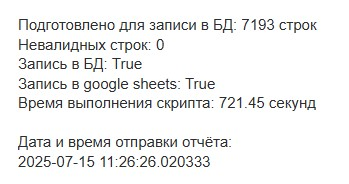

In [4]:
from IPython.display import Image
Image(filename='C:/....jpg')

#### Пример логов

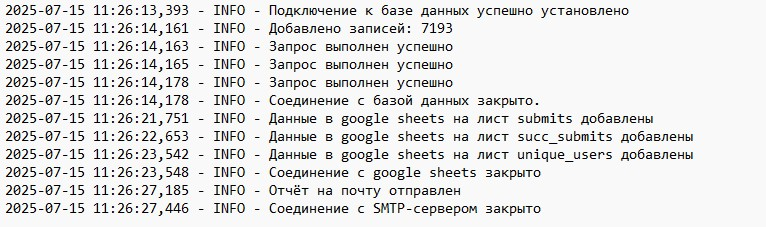

In [6]:
Image(filename='C:/....jpg')